<a href="https://colab.research.google.com/github/Asad1287/50_ML_Projects_50_Days/blob/main/Day3_VanillaMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from IPython.display import display, Math, Markdown

display(Markdown(r"""
# Linear Regression with JAX

This lesson demonstrates solving a simple **linear regression** problem using **JAX**, a high-performance numerical computing library.

### Key Concepts

#### 1. Linear Regression Model
The goal is to predict an output (\(y\)) as a linear function of the input (\(x\)):

\[
y = w \cdot x + b
\]

Where:
- \(w\) is the weight (slope of the line).
- \(b\) is the bias (y-intercept).

---

#### 2. Parameter Initialization
The parameters \(w\) and \(b\) are initialized randomly using JAX’s `random.normal()` function.

---

#### 3. Forward Pass (Prediction)
The forward pass computes predictions as:

\[
y_{\text{pred}} = w \cdot x + b
\]

---

#### 4. Loss Function
The loss function measures how well the model’s predictions match the actual values (\(y\)) using **Mean Squared Error (MSE)**:

\[
\text{MSE} = \frac{1}{N} \sum (y_{\text{pred}} - y)^2
\]

---

#### 5. Backward Pass (Gradient Computation) and Parameter Update
Using **automatic differentiation** (`jax.grad`), the gradients of the loss function with respect to \(w\) and \(b\) are computed. Parameters are updated using **gradient descent**:

\[
w = w - \eta \cdot \frac{\partial \text{Loss}}{\partial w}, \quad
b = b - \eta \cdot \frac{\partial \text{Loss}}{\partial b}
\]

Here, \(\eta\) is the learning rate.

---

#### 6. Training
The model iteratively updates \(w\) and \(b\) over multiple epochs to minimize the loss.

---

#### 7. Visualization
The `plot_actual_vs_predicted` function generates a scatter plot of actual vs. predicted values, along with a dashed line (\(y = x\)) representing the ideal fit.

This plot visually shows how well the model fits the data.
"""))



# Linear Regression with JAX

This lesson demonstrates solving a simple **linear regression** problem using **JAX**, a high-performance numerical computing library.

### Key Concepts

#### 1. Linear Regression Model
The goal is to predict an output (\(y\)) as a linear function of the input (\(x\)):

\[
y = w \cdot x + b
\]

Where:
- \(w\) is the weight (slope of the line).
- \(b\) is the bias (y-intercept).

---

#### 2. Parameter Initialization
The parameters \(w\) and \(b\) are initialized randomly using JAX’s `random.normal()` function.

---

#### 3. Forward Pass (Prediction)
The forward pass computes predictions as:

\[
y_{\text{pred}} = w \cdot x + b
\]

---

#### 4. Loss Function
The loss function measures how well the model’s predictions match the actual values (\(y\)) using **Mean Squared Error (MSE)**:

\[
\text{MSE} = \frac{1}{N} \sum (y_{\text{pred}} - y)^2
\]

---

#### 5. Backward Pass (Gradient Computation) and Parameter Update
Using **automatic differentiation** (`jax.grad`), the gradients of the loss function with respect to \(w\) and \(b\) are computed. Parameters are updated using **gradient descent**:

\[
w = w - \eta \cdot \frac{\partial \text{Loss}}{\partial w}, \quad
b = b - \eta \cdot \frac{\partial \text{Loss}}{\partial b}
\]

Here, \(\eta\) is the learning rate.

---

#### 6. Training
The model iteratively updates \(w\) and \(b\) over multiple epochs to minimize the loss.

---

#### 7. Visualization
The `plot_actual_vs_predicted` function generates a scatter plot of actual vs. predicted values, along with a dashed line (\(y = x\)) representing the ideal fit.

This plot visually shows how well the model fits the data.


In [6]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random, vmap
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, Dict
from functools import partial
class MLP:
    def __init__(self, layer_sizes: Sequence[int], key: jax.random.PRNGKey):
        """Initialize MLP parameters"""
        self.layer_sizes = layer_sizes
        self.params = self.init_network_params(layer_sizes, key)

    def init_network_params(self, sizes: Sequence[int], key: jax.random.PRNGKey) -> list:
        """Initialize all layers using Xavier initialization"""
        keys = random.split(key, len(sizes))
        return [self.init_layer_params(m, n, k)
                for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

    def init_layer_params(self, m: int, n: int, key: jax.random.PRNGKey) -> tuple:
        """Initialize single layer using Xavier initialization"""
        w_key, b_key = random.split(key)
        # Xavier initialization
        w = random.normal(w_key, (n, m)) / jnp.sqrt(m)
        b = random.normal(b_key, (n,))
        return (w, b)

    @staticmethod
    def relu(x):
        """ReLU activation function"""
        return jnp.maximum(0, x)

    def predict(self, params: list, x: jnp.ndarray) -> jnp.ndarray:
        """Forward pass through the network"""
        activations = x
        for w, b in params[:-1]:
            # Reshape b to (64, 1) to allow broadcasting
            activations = self.relu(jnp.dot(w, activations) + b[:, None])

        # Final layer with no activation
        final_w, final_b = params[-1]
        return jnp.dot(final_w, activations) + final_b

    def loss(self, params: list, x: jnp.ndarray, y: jnp.ndarray) -> float:
        """Compute MSE loss"""
        preds = self.predict(params, x)
        return jnp.mean((preds - y) ** 2)

    @partial(jit, static_argnums=(0,))
    def update(self, params: list, x: jnp.ndarray, y: jnp.ndarray,
               learning_rate: float) -> tuple:
        """Compute gradients and update parameters"""
        grads = grad(self.loss)(params, x, y)
        return [(w - learning_rate * dw, b - learning_rate * db)
                for (w, b), (dw, db) in zip(params, grads)]

def generate_data(n_samples: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    """Generate synthetic data for testing"""
    np.random.seed(42)
    X = np.random.randn(n_samples, 2)
    y = np.sum(X**2, axis=1)  # Simple quadratic function
    return X.T, y  # Transpose X to match JAX convention

def train(mlp: MLP, X: jnp.ndarray, y: jnp.ndarray,
          n_epochs: int = 1000, batch_size: int = 32,
          learning_rate: float = 0.01) -> Dict[str, list]:
    """Train the MLP"""
    n_samples = X.shape[1]
    history = {'loss': []}

    for epoch in range(n_epochs):
        # Create batch indices
        perm = jax.random.permutation(random.PRNGKey(epoch), n_samples)
        batches = jnp.array_split(perm, n_samples // batch_size)

        # Train on batches
        epoch_loss = 0.0
        for batch_idx in batches:
            X_batch = X[:, batch_idx]
            y_batch = y[batch_idx]

            # Update parameters
            mlp.params = mlp.update(mlp.params, X_batch, y_batch, learning_rate)

            # Compute batch loss
            batch_loss = mlp.loss(mlp.params, X_batch, y_batch)
            epoch_loss += batch_loss

        avg_epoch_loss = epoch_loss / len(batches)
        history['loss'].append(avg_epoch_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {avg_epoch_loss:.4f}")

    return history

def plot_results(history: Dict[str, list], X: jnp.ndarray, y: jnp.ndarray,
                mlp: MLP) -> None:
    """Plot training history and predictions"""
    plt.figure(figsize=(12, 4))

    # Plot loss history
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

    # Plot predictions vs actual
    plt.subplot(1, 2, 2)
    predictions = vmap(lambda x: mlp.predict(mlp.params, x))(X.T)
    # Reshape predictions to match the shape of y
    predictions = predictions.reshape(y.shape) # Reshape predictions to have the same shape as y
    plt.scatter(y, predictions, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.title('Predictions vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    plt.tight_layout()
    plt.show()

def main():
    # Generate synthetic data
    X, y = generate_data(1000)

    # Initialize MLP
    layer_sizes = [2, 64, 32, 1]  # Input dim: 2, Hidden: [64, 32], Output dim: 1
    mlp = MLP(layer_sizes, random.PRNGKey(0))

    # Train model
    history = train(mlp, X, y, n_epochs=1000, learning_rate=0.01)



    # Test predictions
    test_X = jnp.array([[1.0, 1.0]])  # Example test point
    pred = mlp.predict(mlp.params, test_X.T)
    actual = jnp.sum(test_X**2)
    print(f"\nTest prediction for point {test_X}:")
    # Convert JAX arrays to Python scalars before formatting
    print(f"Predicted: {pred[0].item():.4f}, Actual: {actual.item():.4f}")


if __name__ == "__main__":

    main()

Epoch 0, Loss: 1.8989
Epoch 100, Loss: 0.0048
Epoch 200, Loss: 0.0028
Epoch 300, Loss: 0.0014
Epoch 400, Loss: 0.0016
Epoch 500, Loss: 0.0010
Epoch 600, Loss: 0.0010
Epoch 700, Loss: 0.0009
Epoch 800, Loss: 0.0007
Epoch 900, Loss: 0.0006

Test prediction for point [[1. 1.]]:
Predicted: 2.0307, Actual: 2.0000


In [11]:
def init_layer_params( m: int, n: int, key: jax.random.PRNGKey) -> tuple:
        """Initialize single layer using Xavier initialization"""
        w_key, b_key = random.split(key)
        # Xavier initialization
        w = random.normal(w_key, (n, m)) / jnp.sqrt(m)
        b = random.normal(b_key, (n,))
        return (w, b)

m = 3
n = 3

print(init_layer_params(m, n, random.PRNGKey(0)))

(Array([[-1.5072066 ,  0.01954494,  0.6271948 ],
       [-0.8546509 ,  0.8893069 ,  0.6134439 ],
       [ 0.31277856,  0.00982812,  0.1571943 ]], dtype=float32), Array([ 1.1378784 , -1.2209548 , -0.59153634], dtype=float32))


In [13]:
def relu(x):
        """ReLU activation function"""
        return jnp.maximum(0, x)

relu(jnp.array([-1, 1,2,3]))

Array([0, 1, 2, 3], dtype=int32)

Epoch 0, Loss: 1.0798
Epoch 100, Loss: 0.0104
Epoch 200, Loss: 0.0104
Epoch 300, Loss: 0.0104
Epoch 400, Loss: 0.0104
Epoch 500, Loss: 0.0104
Epoch 600, Loss: 0.0104
Epoch 700, Loss: 0.0104
Epoch 800, Loss: 0.0104
Epoch 900, Loss: 0.0104

Trained Parameters: w = 2.0100, b = -0.9990


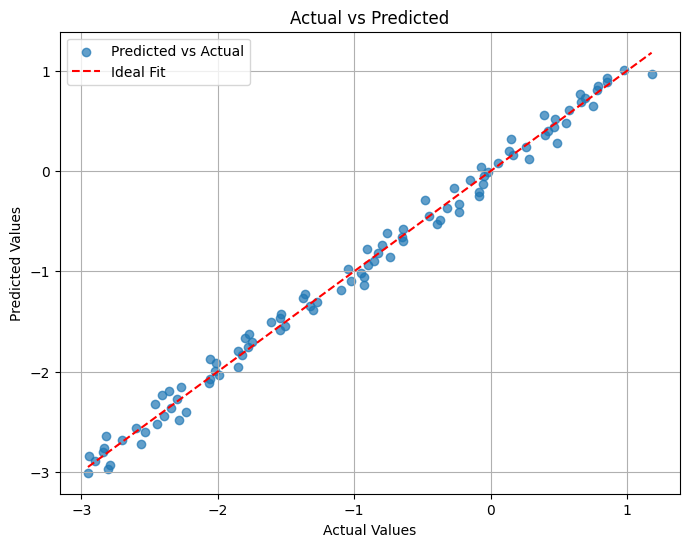

In [14]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import matplotlib.pyplot as plt
from typing import Tuple

# Initialize parameters (weights and bias)
def init_params(key: jax.random.PRNGKey) -> Tuple[jnp.ndarray, jnp.ndarray]:
    w_key, b_key = random.split(key)
    w = random.normal(w_key, (1,))  # Weight (1-D array for linear regression)
    b = random.normal(b_key, (1,))  # Bias (1-D scalar)
    return w, b

# Forward pass (prediction function)
def predict(params: Tuple[jnp.ndarray, jnp.ndarray], x: jnp.ndarray) -> jnp.ndarray:
    w, b = params
    return w * x + b

# Loss function (MSE)
def loss(params: Tuple[jnp.ndarray, jnp.ndarray], x: jnp.ndarray, y: jnp.ndarray) -> float:
    preds = predict(params, x)
    return jnp.mean((preds - y) ** 2)

# Backward pass and parameter update
@jit
def update(params: Tuple[jnp.ndarray, jnp.ndarray], x: jnp.ndarray, y: jnp.ndarray, learning_rate: float) -> Tuple[jnp.ndarray, jnp.ndarray]:
    grads = grad(loss)(params, x, y)
    w, b = params
    dw, db = grads
    w -= learning_rate * dw
    b -= learning_rate * db
    return w, b

# Training function
def train(x: jnp.ndarray, y: jnp.ndarray, n_epochs: int, learning_rate: float) -> Tuple[jnp.ndarray, jnp.ndarray]:
    key = random.PRNGKey(0)
    params = init_params(key)

    for epoch in range(n_epochs):
        params = update(params, x, y, learning_rate)
        if epoch % 100 == 0:
            current_loss = loss(params, x, y)
            print(f"Epoch {epoch}, Loss: {current_loss:.4f}")

    return params

# Plot actual vs predicted
def plot_actual_vs_predicted(x: jnp.ndarray, y: jnp.ndarray, params: Tuple[jnp.ndarray, jnp.ndarray]) -> None:
    """
    Plot the actual vs predicted values.
    """
    y_pred = predict(params, x)
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.7, label="Predicted vs Actual")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal Fit")
    plt.title("Actual vs Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid()
    plt.show()

# Main execution
def main():
    # Generate synthetic data
    key = random.PRNGKey(42)
    x = jnp.linspace(-1, 1, 100)  # Features
    true_w, true_b = 2.0, -1.0  # Ground truth parameters
    y = true_w * x + true_b + 0.1 * random.normal(key, x.shape)  # Add noise

    # Train the model
    learning_rate = 0.1
    n_epochs = 1000
    params = train(x, y, n_epochs, learning_rate)

    # Print final parameters
    w, b = params
    print(f"\nTrained Parameters: w = {w[0]:.4f}, b = {b[0]:.4f}")

    # Plot actual vs predicted
    plot_actual_vs_predicted(x, y, params)

if __name__ == "__main__":
    main()
